In [229]:
import os 
import glob

import numpy as np
import pandas as pd

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

from skimage import io, transform

import matplotlib.pyplot as plt

In [230]:
labels = pd.read_csv('test_data/output/labels.csv', sep=';')

In [231]:
print(len(labels))
print(labels.shape)
labels.head()

1
(1, 3)


,file,dim0,dim1
0,seq1_00001,304.0,357.0


In [242]:
class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, coords = sample['image'], sample['coords']

        h, w = image.shape[:2]
        
        new_h, new_w = self.output_size


        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top: top + new_h, left: left + new_w]
        coords = coords - [top, left]

        return {'image': image, 'coords': coords}

In [233]:
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, coords = sample['image'], sample['coords']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image),
                'coords': torch.from_numpy(coords)}

In [234]:
class Mandelbrotataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.mandelbrot_frame = pd.read_csv(csv_file, sep=';')
        self.root_dir = root_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.mandelbrot_frame)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        # get name of current image
        img_name = self.mandelbrot_frame.iloc[idx, 0].split('_')
        full_name = os.path.join(
            self.root_dir,
            img_name[0],
            img_name[1] + '.jpg'
            )
        
        # load current image
        image = io.imread(full_name)
        coords = self.mandelbrot_frame.iloc[idx, 1:]
        coords = np.asarray([coords])
        coords = coords.astype('float').reshape(-1, 2)
        
        sample = {'image': image, 'coords': coords}
        
        if self.transform:
            sample = transform(sample)
            
        return sample

In [235]:
m_dataset = Mandelbrotataset('test_data/output/labels.csv', 'test_data/input/')

for i in range(len(m_dataset)):
    data_point = m_dataset[i]
    print(data_point['coords'])
    break

[[304. 357.]]


In [243]:
composed = transforms.Compose([RandomCrop((340, 360)), ToTensor()])

In [244]:
def show_landmarks(image, coords):
    """Show image with landmarks"""
    plt.imshow(image)
    plt.scatter(coords[:, 0], coords[:, 1], s=10, marker='.', c='r')
    plt.pause(0.001)  # pause a bit so that plots are updated

[[304. 357.]]


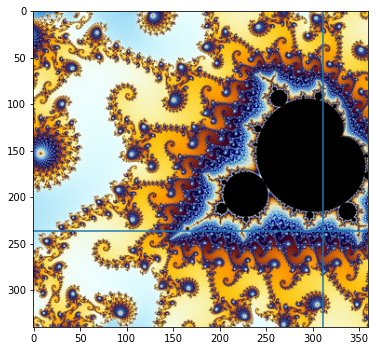

[[304. 357.]]


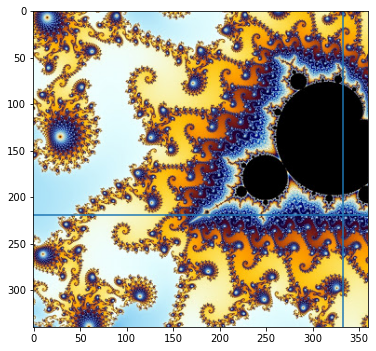

[[304. 357.]]


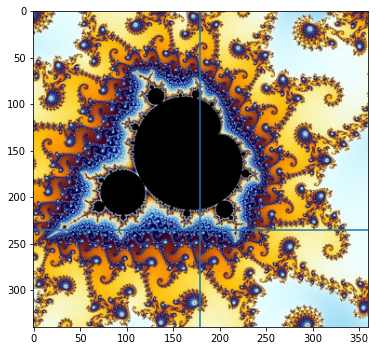

[[304. 357.]]


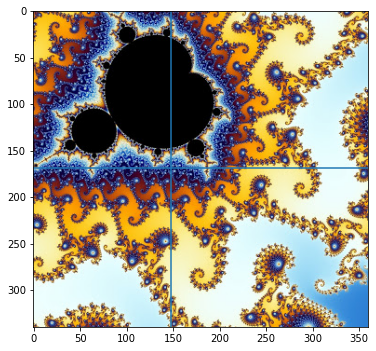

[[304. 357.]]


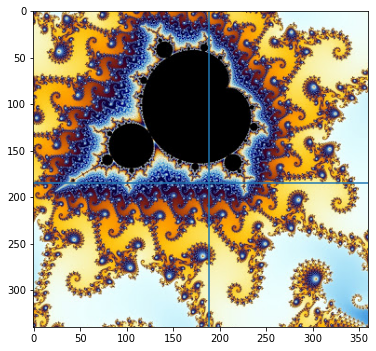

[[304. 357.]]


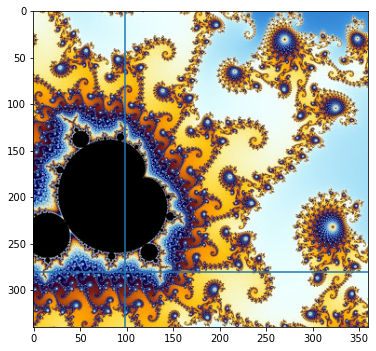

[[304. 357.]]


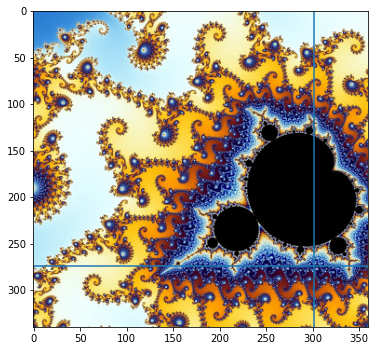

[[304. 357.]]


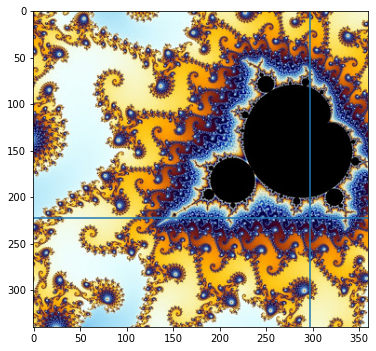

[[304. 357.]]


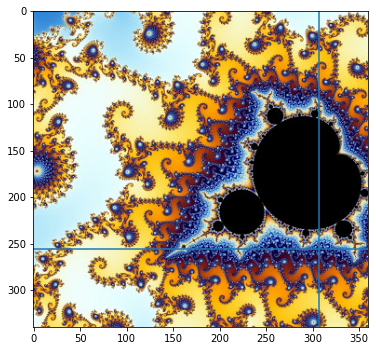

[[304. 357.]]


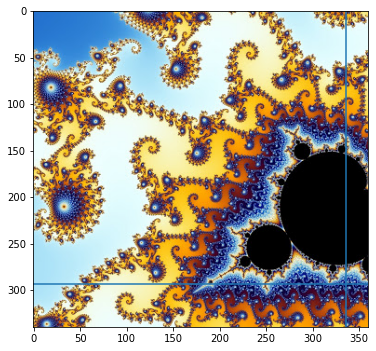

In [246]:
sample = m_dataset[0]

for _ in range(10):
    
    fig = plt.figure(figsize=(6,8))
    
    for i, tsfrm in enumerate([composed]):
        print(sample['coords'])
        transformed_sample = tsfrm(sample)

        image = transformed_sample['image']
        coords = transformed_sample['coords']
        #print()
        plt.imshow(image.permute(1,2,0))
        plt.axhline(y=coords[0][0].item())
        plt.axvline(x=coords[0][1].item())
        plt.show()

# 